In [3]:
from dataset import Dataset
from skimage import io as sio
from skimage.feature import daisy
from matplotlib import pyplot as plt
import numpy as np
from time import time
from sklearn.cluster import MiniBatchKMeans as KMeans
import warnings

warnings.filterwarnings("ignore")

dataset = Dataset('Caltech101')
classes = dataset.getClasses()[10:20]
dataset.restrictDataset(classes)

0

In [4]:
training_set,test_set = dataset.splitTrainingTest(0.7)
print (training_set.getLength())
print (test_set.getLength())

466
205


In [6]:
def extract_features(data_set):
    tmp_list = list()
    img_processed = 0
    img_tot = data_set.getLength()
    print("Inizio il processing...")
    classes = data_set.getClasses()
    for class_name in classes:
        size = data_set.getClassLength(class_name)
        print("Class: {} - Images: {}".format(class_name,size))
        for i in range(size):
            im = sio.imread(data_set.getImagePath(class_name,i),as_grey=True)
            daisy_features = daisy(img=im,step=10).reshape(-1,200)
            tmp_list.append(daisy_features)
        img_processed+=data_set.getClassLength(class_name)
        print("Processate: {:<5} su {:<7}".format(img_processed,img_tot))
    return np.vstack(tmp_list)

In [4]:
training_local_features = extract_features(training_set)

Inizio il processing...
Class: bass - Images: 37
Processate: 37    su 466    
Class: beaver - Images: 32
Processate: 69    su 466    
Class: binocular - Images: 23
Processate: 92    su 466    
Class: bonsai - Images: 89
Processate: 181   su 466    
Class: brain - Images: 68
Processate: 249   su 466    
Class: brontosaurus - Images: 30
Processate: 279   su 466    
Class: buddha - Images: 59
Processate: 338   su 466    
Class: butterfly - Images: 63
Processate: 401   su 466    
Class: camera - Images: 35
Processate: 436   su 466    
Class: cannon - Images: 30
Processate: 466   su 466    


In [6]:
training_local_features.shape

(261333, 200)

In [7]:
#inizializziamo l'oggetto "KMeans" impostando il numero di centroidi
kmeans = KMeans(1000)
#avviamo il kmeans sulle feature estratte
start_time=time()
kmeans.fit(training_local_features)
end_time=time()
elapsed_time=end_time-start_time
print ("Total time: {0:0.2f} sec".format(elapsed_time))

Total time: 77.30 sec


In [8]:
kmeans.cluster_centers_.shape

(1000, 200)

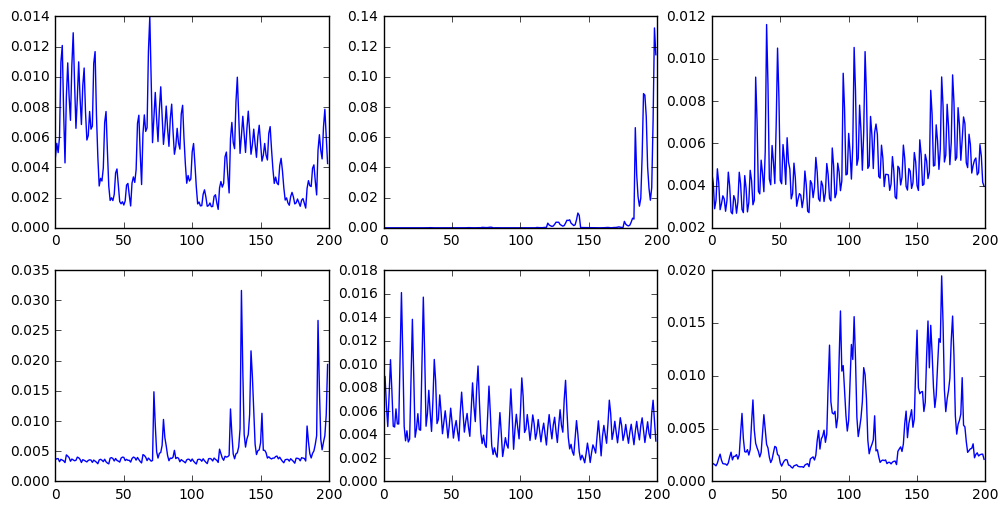

In [9]:
centers = np.random.permutation(kmeans.cluster_centers_)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(centers[i])

plt.show()

In [10]:
from skimage.color import rgb2grey

def extract_and_describe(image,kmeans_dict):
    #converts from rgb to grayscale
    img_grey = rgb2grey(image)
    # extract the features
    daisy_features = daisy(img_grey,step=10).reshape(-1,200)
    # predicts the nearest kmeans centres for each feature
    assignments = kmeans_dict.predict(daisy_features)
    # generate a series of histogram for each centroid
    bovw_graph, _ =np.histogram(assignments,bins=500,range=(0,499)) 
    return bovw_graph

In [115]:
classes_idx=range(len(classes)) #genera numeri interi da zero a len(classes)-1

#print (classes)
#print (classes_idx)
index = {i:class_name for i,class_name in enumerate(classes)}
sorted(index.values())
index

{0: 'bass',
 1: 'beaver',
 2: 'binocular',
 3: 'bonsai',
 4: 'brain',
 5: 'brontosaurus',
 6: 'buddha',
 7: 'butterfly',
 8: 'camera',
 9: 'cannon'}

In [12]:
def describe_dataset(dataset,kmeans):
    y=list()
    X=list()
    paths=list()
    
    classes = dataset.getClasses()
    total_image= dataset.getLength()
    current_image=0
    start_time=time()
    for class_name in classes:
        for path in dataset.getImagePath(class_name,"all"):
            img=sio.imread(path,as_grey=True)
            feature = extract_and_describe(img,kmeans)
            X.append(feature)
            y.append(classes.index(class_name))
            paths.append(path)
            current_image+=1
            #print("Processing: {:<3} of {:<3}".format(current_image,total_image))
    X=np.array(X)
    y=np.array(y)
    end_time=time()
    print("Elapsed time: {0:0.2f}".format(end_time-start_time))
    return X,y,paths
    

In [13]:
X_training,y_training,paths_training=describe_dataset(training_set,kmeans)
X_test,y_test,paths_test=describe_dataset(test_set,kmeans)

Elapsed time: 121.18
Elapsed time: 56.65


In [14]:
def display_image_and_representation(X,y,paths,classes,idx):
    info = paths[idx].split('/')
    title="Class: {} - Picture: {}".format(info[1],info[2])
    plt.figure(figsize=(12,6))
    plt.figtext(x=0.5,y=1,s=title,horizontalalignment='center',fontsize=14)
    plt.subplot(1,2,1)
    im = sio.imread(paths[idx])
    plt.imshow(im)
    plt.subplot(1,2,2)
    plt.plot(X[idx])
    plt.show()

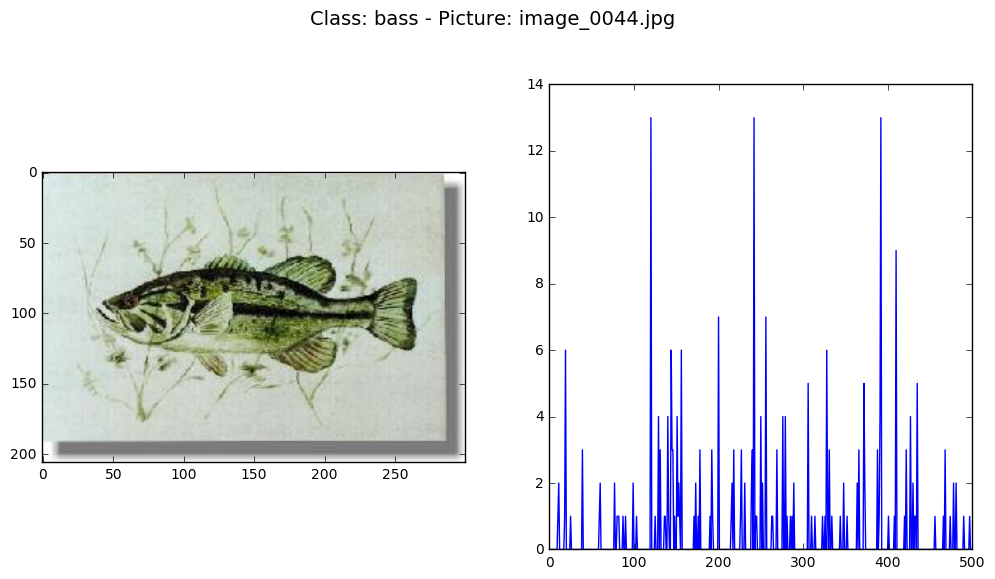

In [15]:
display_image_and_representation(X_training,y_training,paths_training,classes,0)

In [16]:
from sklearn.preprocessing import Normalizer

norm = Normalizer(norm='l1')

X_training_l1 = norm.transform(X_training)
X_test_l1 = norm.transform(X_test)

In [17]:
def compare_representations(bovw_representation,normalized_bovw_representation):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Occorrenze")
    plt.plot(bovw_representation)
    plt.subplot(1,2,2)
    plt.title("Normalizzato")
    plt.plot(normalized_bovw_representation)
    plt.show()

In [18]:
#binarizziamo il vettore di rappresentazioni X_training
#otterremo una matrice n x 5000 in cui l'elemento x_ij
#indica se la parola j-esima era presente nell'immagine i-esima
presence = (X_training>0).astype(int)
#sommiamo tutte le righe (asse "0" della matrice)
#ogni elemento del vettore risultate indicherà il numero di
#righe (=immagini) in cui la parola visuale era presente
df = presence.sum(axis=0)

In [19]:
#otteniamo prima il numero di immagini
n=len(X_training)
#calcoliamo il termine secondo la formula riportata prima
idf = np.log(float(n)/(1+df))

In [20]:
X_training_tfidf=X_training*idf
X_test_tfidf=X_test*idf

In [21]:
norm = Normalizer(norm='l2')

X_training_tfidf_l2 = norm.transform(X_training_tfidf)
X_test_tfidf_l2 = norm.transform(X_test_tfidf)

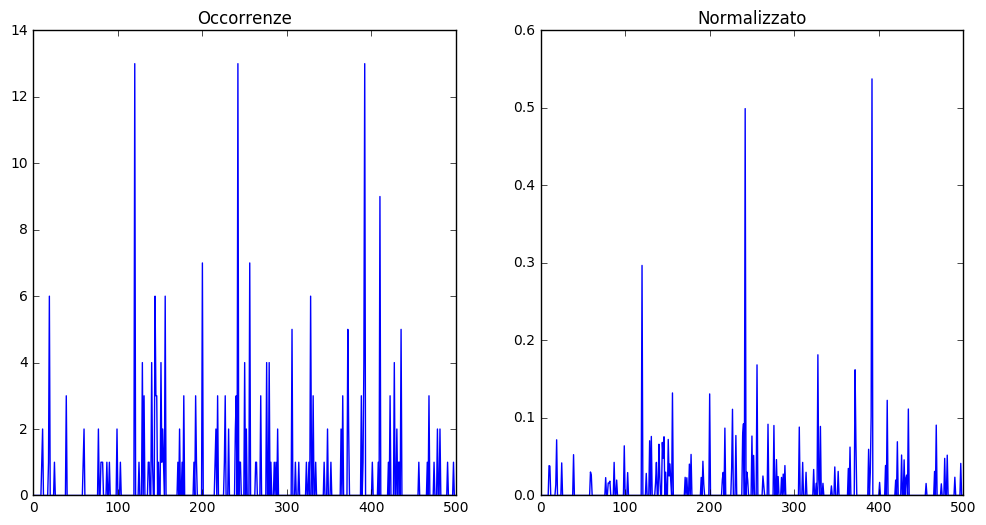

In [22]:
compare_representations(X_training[0],X_training_tfidf_l2[0])

In [23]:
from sklearn.neighbors import KDTree

tree = KDTree(X_training_tfidf_l2)
#L'oggetto KDTree appea creato ha "memorizzato" e "indicizzato" opportunamente il training set 
#per effettuare delle "query" in maniera efficiente

In [24]:
def query_image(tree,paths_training,paths_test,X_test_tfidf_l2,idx):
    query_representation = X_test_tfidf_l2[idx]
    _, closest_idx = tree.query(query_representation)
    
    query_im = sio.imread(paths_test[idx])
    closest_im = sio.imread(paths_training[closest_idx[0,0]])
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(query_im)
    info = paths_test[idx].split('/')
    plt.title("Query Image - Class: "+info[1])
    
    plt.subplot(1,2,2)
    plt.imshow(closest_im)
    info = paths_training[closest_idx[0,0]].split('/')
    plt.title("Closest Image - Class: "+info[1])
    
    plt.show()

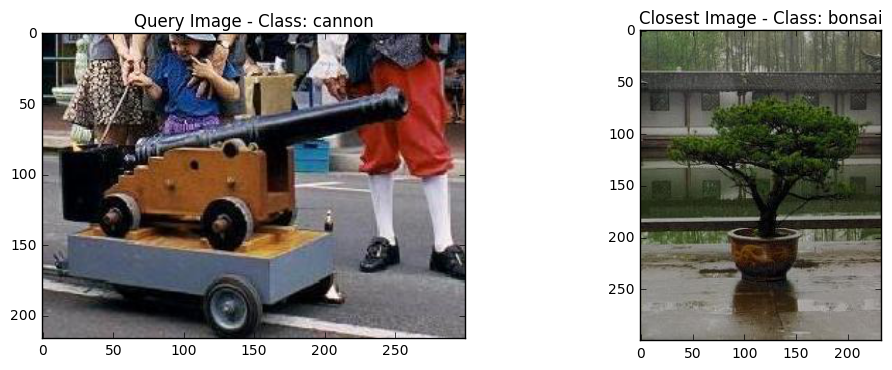

In [131]:
random_idx = np.random.randint(len(X_test_tfidf_l2))
query_image(tree,paths_training,paths_test,X_test_tfidf_l2,random_idx)

In [26]:
def three_closest(tree,paths_training,paths_test,X_test_tfidf_l2,idx):
    query_representation = X_test_tfidf_l2[idx]
    _, closest_idx = tree.query(query_representation,k=3)
    query_im = sio.imread(paths_test[idx])
    closest_im1 = sio.imread(paths_training[closest_idx[0,0]])
    closest_im2 = sio.imread(paths_training[closest_idx[0,1]])
    closest_im3 = sio.imread(paths_training[closest_idx[0,2]])
    
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1)
    plt.imshow(query_im)
    info = paths_test[idx].split('/')
    plt.title("Query Image - Class: "+info[1])
    
    plt.subplot(2,2,2)
    plt.imshow(closest_im1)
    info = paths_training[closest_idx[0,0]].split('/')
    plt.title("Closest Image1 - Class: "+info[1])
    
    plt.subplot(2,2,3)
    plt.imshow(closest_im2)
    info = paths_training[closest_idx[0,1]].split('/')
    plt.title("Closest Image2 - Class: "+info[1])
    plt.subplot(2,2,4)
    plt.imshow(closest_im3)
    info = paths_training[closest_idx[0,2]].split('/')
    plt.title("Closest Image3 - Class: "+info[1])
    
    plt.show()

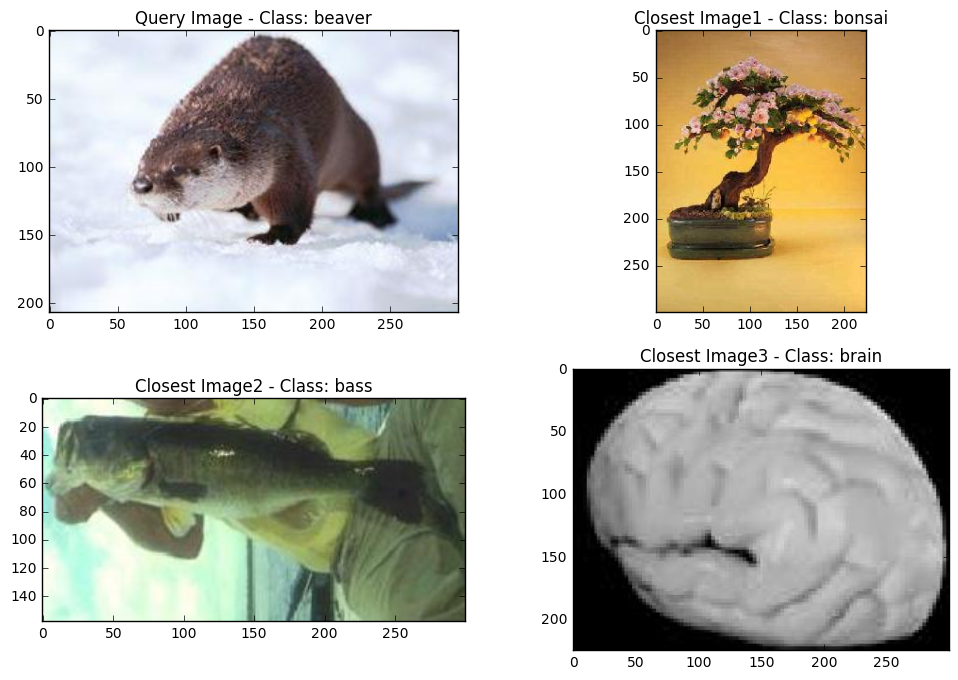

In [130]:
random_idx = np.random.randint(len(X_test_tfidf_l2))
three_closest(tree,paths_training,paths_test,X_test_tfidf_l2,random_idx)

In [28]:
import _pickle as cPickle

#la keyword with permette di creare contesti in python
#i contesti sono delle porzioni di codice nelle quali viene
#resa disponibile una determinata risorsa, nel nostro caso
#il file pkl su cui scrivere i dati
with open("caltech101_bovw(10-20).pkl",'wb') as out:
    cPickle.dump({ #per scrivere più dati, li inseriamo dentro un dizionario
            'X_training':X_training,
            'X_training_l1':X_training_l1,
            'X_training_tfidf_l2':X_training_tfidf_l2,
            'y_training':y_training,
            'paths_training':paths_training,
            'X_test':X_test,
            'X_test_l1':X_test_l1,
            'X_test_tfidf_l2':X_test_tfidf_l2,
            'y_test':y_test,
            'paths_test':paths_test,
            'classes':classes,
            'kmeans':kmeans
        },out)

def load_dump():
    with open("caltech101_bovw.pkl") as inp:
        return cPickle.load(inp)

In [29]:
# Matrice nx500 in cui l'elemento x_ij indica la probabilità che la parola j-esima sia presente nell'immagine i-esima
X_training_tfidf_l2.shape
# Matrice nx500 in cui l'elemento x_ij indica il numero di occorrenze che la parola j-esima ha nell'immagine i-esima
X_training.shape

(466, 500)

# Naive Bayes 

In [127]:
from collections import Counter

class naive_bayes:
    def __init__(self,X_set,y_set):
        self.X = np.array(X_set)
        self.y = np.array(y_set)
        self.V = X_set.shape[1]

    def fit(self):
        self.counter = Counter(self.y)
        self.Prob_cj = [cl/float(len(self.y)) for cl in self.counter.values()]
    
    def predict(self,img):
        probability = []
        for cl in self.counter:
            Prob_words = []
            for feature in range(self.V):
                Prob_words.append( (1+np.sum(self.X[i,feature] for i, x in enumerate(self.y) if x==cl))/ \
                                  (self.V + np.sum(self.X[i,:] for i, x in enumerate(self.y) if x==cl)) )
            probability.append( np.log(self.Prob_cj[cl]) + np.sum(img*np.log(Prob_words).T) )
        return np.argmax(probability)

Caltech101/camera/image_0049.jpg


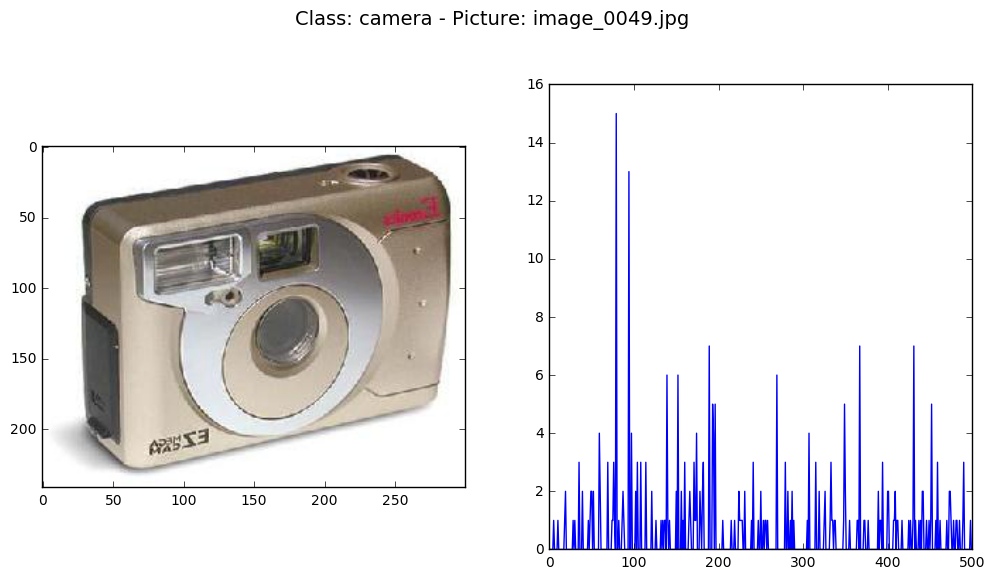

camera


In [133]:
nb = naive_bayes(X_training,y_training)
random_idx = np.random.randint(len(X_test))
print(paths_test[random_idx])
nb.fit()
predicted = nb.predict(X_test[random_idx])
display_image_and_representation(X_test,y_test,paths_test,classes,random_idx)
print(index[predicted])

In [223]:
def class_ratio(dataset):
    p_cj = list()
    for class_name in dataset.getClasses():
        p_cj.append((dataset.getClassLength(class_name))/dataset.getLength())
    return np.array(p_cj)  

def getClassFromWord(X_training,dataset,index,class_probability):
    #numero totale di volte che Vt è presente in C
    total_occurrence = X_training.sum(axis=0)
    #numero totale di volte che Vt è presente in Cj
    class_occurrence = np.empty(shape=[len(index),X_training.shape[1]])
    offset=0
    for class_name in index:
        class_occurrence[index[class_name]]=(X_training[offset:(offset+dataset.getClassLength(class_name))].sum(axis=0))
    #probabilita che data una Vt questa sia un Cj
    return np.vstack(row/(total_occurrence*X_training.shape[1]) for row in class_occurrence)

def findTheClass(dataset,X_training,index,image_query):
    class_probability = class_ratio(dataset)
    PVt_Cj = getClassFromWord(X_training,dataset,index,class_probability)
    p_class = list()
    print(class_probability.shape)
    print(PVt_Cj.shape)
    #bayes = np.vstack(np.log(class_probability)+np.dot(image_query,np.array((np.log(row))[np.newaxis]).T) for row in PVt_Cj)
    #for j,row in enumerate(PVt_Cj):
    a = np.array((np.log(PVt_Cj[0]))[np.newaxis]).T
    print(a)
    bayes = np.dot(image_query,a)
    print (bayes)
    p_class.append(np.log(class_probability[j])+bayes)
    print(np.array(p_class).shape)
    return np.argmax(np.array(p_class),axis=0),p_class